In [185]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [186]:
from sortedcontainers import SortedList
from random import random
import matplotlib.pyplot as plt
from matplotlib import colors
from math import pow, log,exp
import time
import sys
from IPython.display import display, clear_output
import numpy as np

A recreation of the mode in:

[Galera, E., Guilherme Roncaratti Galanti, and Osame Kinouchi. "Invasion percolation solves Fermi Paradox but challenges SETI projects." International Journal of Astrobiology 18.4 (2019): 316-322.
](https://www.cambridge.org/core/journals/international-journal-of-astrobiology/article/abs/invasion-percolation-solves-fermi-paradox-but-challenges-seti-projects/92013B48A6A33F98816A417B0254CE68)



"The simulations are done in a square lattice with edge L = 100 that
will represent a portion of the Galaxy (the relation with true astro-
nomical size is discussed later). Our model is two-dimensional
because to consider the thickness of the Galaxy will not change
the main conclusions. Each site (i, j), i = 1, …, L; j = 1, …, L
has a habitability barrier Eij∈[0, 1], which is an uniform random
number generated and fixed from the start of the simulation
(quenched disorder). This number intends to represent how
hard it is to find a habitable planet in the unitary square with
coordinates (i, j): the lower Eij, the easier to colonize that region.
We discuss other choices for P(Eij ) later.
Each site represents an area of D × D ly2 and can have two
states: Sij = 0 (unoccupied) and Sij = 1 (colonized). We start with
a single occupied site (the seed) at the centre of the lattice that
represents a single mother civilization. Then, at the next time
step, this civilization tries to colonize all its four nearest neighbours
with indexes k = i ± 1, l = j ± 1 with probability P(Skl = 1) = p(E) =
exp(−β Ekl )."

In [187]:
def landscape(roughness,levels = 11):
    """
    The landscape function creates a two dimensional fractal matrix of 1 and -1
    """
    
    size = 2 ** (levels - 1)
    height  = np.zeros((size + 1, size + 1))

    for lev in range(levels):
        step = size // 2 ** lev
        for y in range(0, size + 1, step):
            jumpover = 1 - (y // step) % 2 if lev > 0 else 0
            for x in range(step * jumpover, size + 1, step * (1 + jumpover)):
                pointer = 1 - (x // step) % 2 + 2 * jumpover if lev > 0 else 3
                yref, xref = step * (1 - pointer // 2), step * (1 - pointer % 2)
                corner1 = height[y - yref, x - xref]
                corner2 = height[y + yref, x + xref]
                average = (corner1 + corner2) / 2.0
                variation = (pow( step,roughness)) * (random() - 0.5)
                height[y,x] = average + variation if lev > 0 else 0
                
    n_max = height.max()
    n_min = height.min()
    for x in range(0,size+1):
        for y in range(0,size+1):
            height[x,y]=(height[x,y]-n_min)/(n_max-n_min)
    return size,height

In [188]:
def grow(t,x,y,event_stack,beta):
    def add_event(x1,y1):
            event_stack.add([t+exp(space[x1][y1]*beta),x1,y1])

    # stop when edge reached
    if colonies[x][y]<0:
        return False
    if colonies[x][y]==0:
        # if empty set to colinised
        colonies[x][y]=1
        # and add growth into the cordinates of the neighbours at a random time into the event loop 
        add_event(x+1,y)
        add_event(x-1,y)
        add_event(x,y+1)
        add_event(x,y-1)
        
    return True
    

In [189]:
size,space = landscape(0)
beta=25

event_stack=SortedList([])
#set all as edge -1

colonies=[[-1]*size for i in range(size)]

# set all but edge as empty 0 
for x in range(1,size-1):
    for y in range(1,size-1):
        colonies[x][y]=0
# seed colony at mid point
_=grow(0,size//2,size//2,event_stack,beta)

In [190]:
start = time.time()
iterations=0
flag = True
t=0
while(t<8E+07):
    # get earliestpow event from stack ( stack is self sorting by event time)
    e = event_stack.pop(0) 
    flag = grow(e[0],e[1],e[2],event_stack,beta)

    iterations+=1
    t=e[0]
end = time.time()
delta = end - start
ccs=(sum([i.count(1) for i in colonies]))
print(f'{ccs} colonies when the edge of space reached in: {t:.3E} simulated time and {iterations} iterations and {delta:.3F} real seconds')

892750 colonies when the edge of space reached in: 8.000E+07 simulated time and 3491791 iterations and 13.745 real seconds


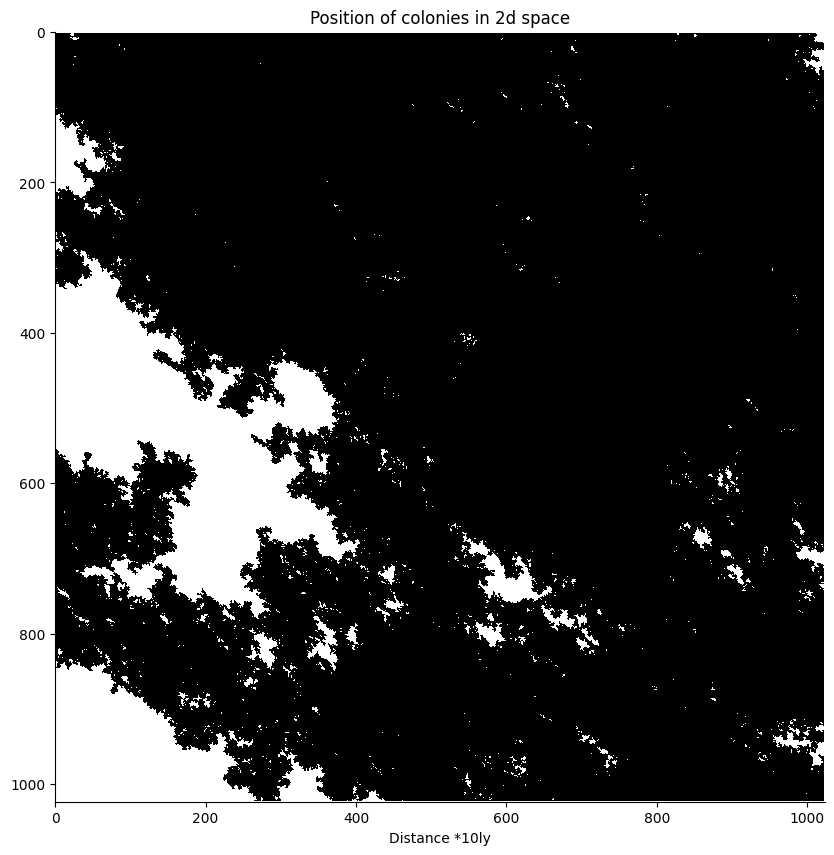

In [191]:
cmap=colors.ListedColormap(['#ffffff','#ffffff','#000000'])
fig, ax = plt.subplots()
ax.imshow(colonies,cmap=cmap)
ax.set_title('Position of colonies in 2d space')
ax.set_xlabel("Distance *10ly")
fig.set_figwidth(10)
fig.set_figheight(10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

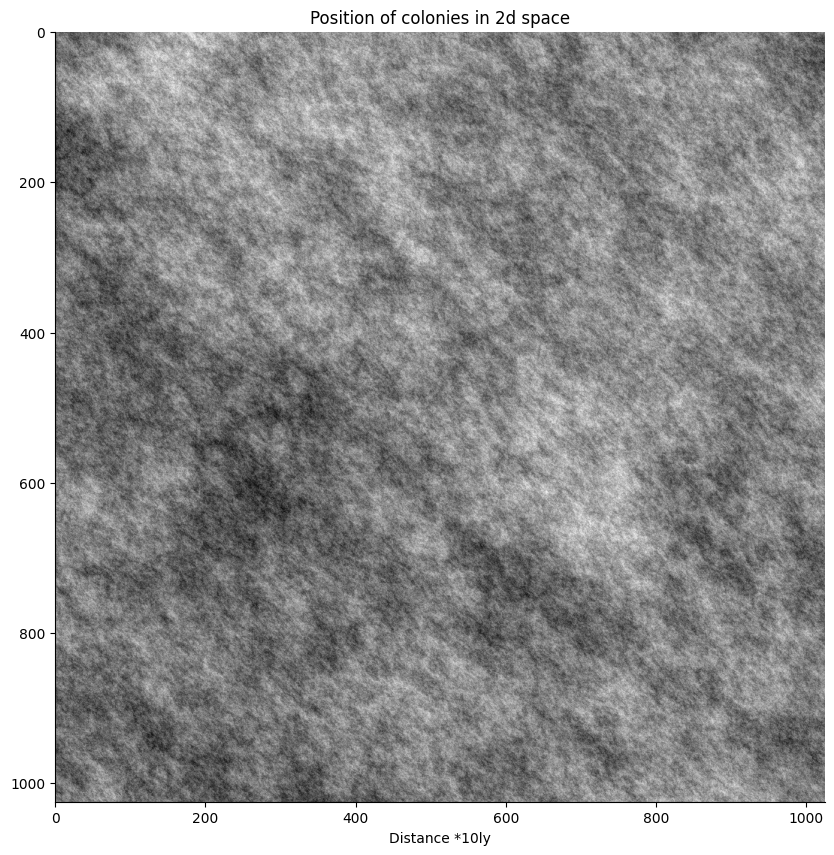

In [192]:
fig, ax = plt.subplots()
ax.imshow(space,cmap = 'binary')
ax.set_title('Position of colonies in 2d space')
ax.set_xlabel("Distance *10ly")
fig.set_figwidth(10)
fig.set_figheight(10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

## Analysis

In [193]:
def queCount(area,size,x,y,n):
    
    def check_validity(x,y):
        if[x,y] in q or x < 1 or x >= size or y < 1 or y >= size or area[x][y] != 0:
            return False
        return True
    
    q=[[x,y]]
    count =0
    while (len(q)>0):
        x1,y1 = q.pop(0)
        area[x1][y1]=n
        count+=1
        if check_validity(x1+1,y1):
            q.append([x1+1,y1])
        if check_validity(x1-1,y1):
            q.append([x1-1,y1])
        if check_validity(x1,y1+1):
            q.append([x1,y1+1])
        if check_validity(x1,y1-1):
            q.append([x1,y1-1])
    return count


In [194]:
gaps={}
cols={}
mark=2
for x in range(1,size-1):
    for y in range(1,size-1):
        if colonies[x][y]==0:
            sz =queCount(colonies,size-1,x,y,mark)
            if sz not in gaps:
                gaps[sz]=0
            cols[mark]=sz
            gaps[sz]+=1
            mark+=1

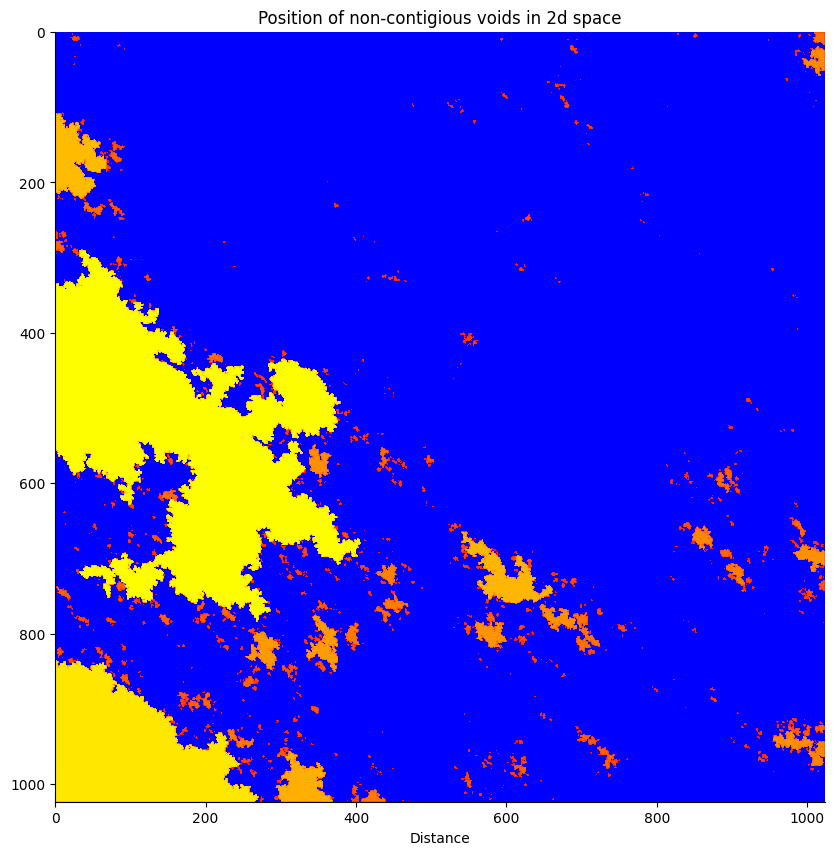

In [195]:
spaces=[[0]*size for i in range(size)]
max_size=0
for x in range(1,size-1):
    for y in range(1,size-1):
        if colonies[x][y]>2:
            spaces[x][y]=cols[colonies[x][y]]
            if(cols[colonies[x][y]]>max_size):
                max_size=cols[colonies[x][y]]
        else:
            spaces[x][y]=colonies[x][y]

c=[(0,0,1),(0,0,1)]
for i in range(3,max_size):
    c.append((1,log(i)/log(max_size),0))


cmap=colors.ListedColormap(c)
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax.set_title('Position of non-contigious voids in 2d space')
ax.set_xlabel("Distance")
ax.imshow(spaces,cmap=cmap)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

Colours show the size of the voids. The more yellow the colour the larger the void. Note that while the size distribution is fractal ( see graph below) their spatial distribution is towards the periphery of the colony cluster

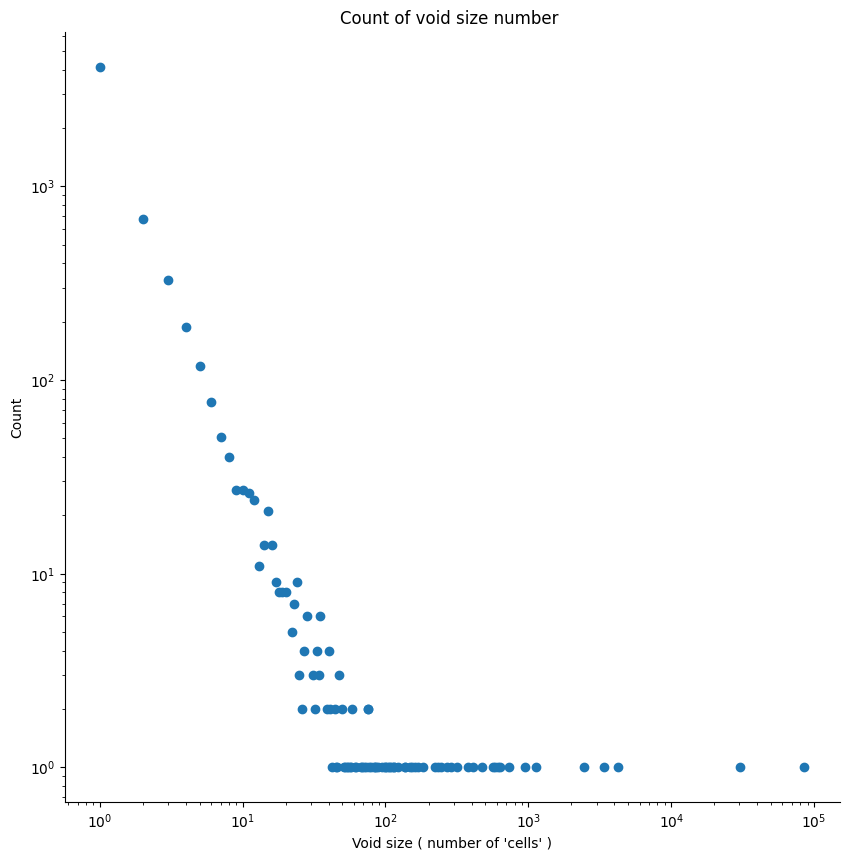

In [196]:
x=list(gaps.keys())
y=list(gaps.values())
fig, ax = plt.subplots()
ax.scatter(x[1:],y[1:])
ax.set_title('Count of void size number ')
ax.set_xlabel("Void size ( number of 'cells' )")
ax.set_ylabel('Count')
fig.set_figwidth(10)
fig.set_figheight(10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()